# Anomalia bouguer para o Havaí

## Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import verde as vd
import pyproj
import boule as bl
import harmonica as hm

In [2]:
notebook_name = '8. Vitoria_Trindade_Chain_bouguer_anomaly.ipynb'

### Plot style

In [3]:
plt.style.use('ggplot')

### Carregando os dados

In [4]:
fname = 'data_set/gravity_VTC_005deg_EIGEN-6C4.gdf'

In [5]:
data = hm.load_icgem_gdf(fname)

In [6]:
fname = 'data_set/geoid_VTC_005deg_EIGEN-6C4.gdf'

In [7]:
geoide = hm.load_icgem_gdf(fname)

In [8]:
data['geoid'] = geoide.geoid

In [9]:
fname = 'data_set/topography_VTC_etopo1.gdf'

In [10]:
topografia = hm.load_icgem_gdf(fname) 

In [11]:
data['topography'] = topografia.topography_shm

In [12]:
data

<xarray.Dataset>
Dimensions:        (latitude: 121, longitude: 301)
Coordinates:
  * longitude      (longitude) float64 319.0 319.1 319.1 ... 333.9 333.9 334.0
  * latitude       (latitude) float64 -23.0 -22.95 -22.9 ... -17.1 -17.05 -17.0
Data variables:
    h_over_geoid   (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    gravity_earth  (latitude, longitude) float64 9.789e+05 ... 9.784e+05
    geoid          (latitude, longitude) float64 -5.231 -5.439 ... -7.19 -7.205
    topography     (latitude, longitude) float64 -86.62 -82.41 ... -5.386e+03
Attributes: (12/32)
    generating_institute:  gfz-potsdam
    generating_date:       2021/09/17
    product_type:          gravity_field
    body:                  earth
    modelname:             EIGEN-6C4
    max_used_degree:       2190
    ...                    ...
    maxvalue:              9.7893972E+05 mgal
    minvalue:              9.7829389E+05 mgal
    signal_wrms:           1.0679475E+02 mgal
    grid_format:           long_lat_height_value
    attributes:            longitude latitude h_over_geoid gravity_earth
    attributes_units:      deg. deg. meter mgal

### Informações sobre a região e os dados

In [13]:
region = (-41,-26,-23,-17)

### Cálculo da gravidade normal

In [14]:
elipsoide = bl.WGS84

In [15]:
data['gamma'] = elipsoide.normal_gravity(data.latitude,data.h_over_geoid)

### Cálculo do distúrbio

In [16]:
data['disturbance'] = data.gravity_earth - data.gamma

### Cálculo da anomalia bouguer 

In [17]:
data['h_over_ell'] = data.geoid + data.topography
bouguer = hm.bouguer_correction(data.h_over_ell)
data['disturbance_bouguer'] = data.disturbance - bouguer

## Campo de gravidade, gravidade normal e distúrbio

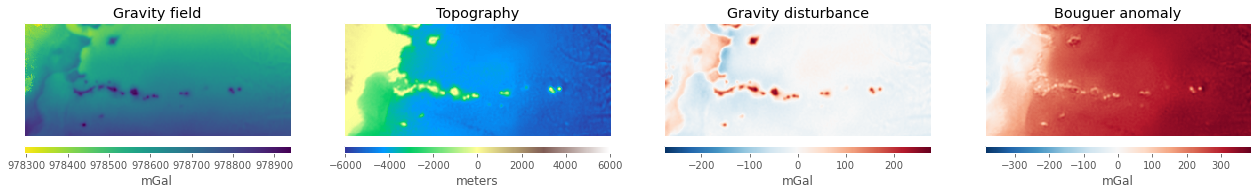

In [18]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(22, 18), subplot_kw=dict(projection=ccrs.Mercator()))

pg = data.gravity_earth.plot.pcolormesh(ax=ax1, cmap="viridis_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pg, ax=ax1, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax1.set_title("Gravity field")
ax1.set_extent(region,crs=ccrs.PlateCarree())

pn = data.h_over_ell.plot.pcolormesh(ax=ax2, cmap="terrain", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pn, ax=ax2, orientation="horizontal", pad=0.01, aspect=40, label="meters")
ax2.set_title("Topography")
ax2.set_extent(region,crs=ccrs.PlateCarree())

pd = data.disturbance.plot.pcolormesh(ax=ax3, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pd, ax=ax3, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax3.set_title("Gravity disturbance")
ax3.set_extent(region,crs=ccrs.PlateCarree())

pb = data.disturbance_bouguer.plot.pcolormesh(ax=ax4, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pb, ax=ax4, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax4.set_title("Bouguer anomaly")
ax4.set_extent(region,crs=ccrs.PlateCarree())

file_name = 'images/gravity_Hawaii'
plt.savefig(file_name+'.png',dpi=300)

plt.show()

## Visualização dos dados em um perfil

### Definindo as coordenadas em um grid regular e as coordenadas dos perfis

In [19]:
step = 0.05

In [20]:
longitude = np.arange(region[0],region[1]+step,step=step)
latitude = np.arange(region[2],region[3]+step,step=step)[:-1]

In [21]:
long,lat = np.meshgrid(longitude,latitude)

In [22]:
full_coordinates = (long,lat)

In [23]:
start = (-34.8,-19)
end = (-34.8,-22)

### Decimando os dados de distúrbio

In [24]:
spacing = 1/60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, disturbance = reducer.filter(
    (long,lat), data.disturbance.values)

In [25]:
projection = pyproj.Proj(proj="merc", lat_ts=coordinates[1].mean())
proj_coords = projection(*coordinates)

### Interpolação dos dados

In [26]:
spline = vd.ScipyGridder(method='cubic')

#### Perfil do distúrbio

In [27]:
interpolate_dist = spline.fit(proj_coords,disturbance)

In [28]:
profile_dist = interpolate_dist.profile(
    point1=start,
    point2=end, 
    size=200, 
    dims=("latitude","longitude"),
    data_names=["disturbance"],
    projection=projection,)

In [29]:
profile_dist

,latitude,longitude,distance,disturbance
0,-19.000000,-34.8,0.000000,-4.356524
1,-19.015221,-34.8,1674.601442,-4.527199
2,-19.030441,-34.8,3349.202884,-4.526737
3,-19.045659,-34.8,5023.804327,-4.463625
4,-19.060876,-34.8,6698.405769,-4.411260
...,...,...,...,...
195,-21.940295,-34.8,326547.281230,-25.225401
196,-21.955224,-34.8,328221.882672,-24.698325
197,-21.970151,-34.8,329896.484115,-24.106171
198,-21.985076,-34.8,331571.085557,-23.458310


### Decimando os dados de topografia

In [30]:
spacing = 1/60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, topography = reducer.filter(
    (long,lat), data.h_over_ell.values)

In [31]:
interpolate_topo = spline.fit(proj_coords,topography)

#### Perfil dos dados de topografia

In [32]:
profile_topo = interpolate_topo.profile(
    point1=start,
    point2=end, 
    size=200, 
    dims=("latitude","longitude"),
    data_names=["topography"],
    projection=projection,)

In [33]:
profile_topo

,latitude,longitude,distance,topography
0,-19.000000,-34.8,0.000000,-4208.562226
1,-19.015221,-34.8,1674.601442,-4196.644846
2,-19.030441,-34.8,3349.202884,-4183.620127
3,-19.045659,-34.8,5023.804327,-4171.104239
4,-19.060876,-34.8,6698.405769,-4160.867565
...,...,...,...,...
195,-21.940295,-34.8,326547.281230,-4563.572949
196,-21.955224,-34.8,328221.882672,-4556.522799
197,-21.970151,-34.8,329896.484115,-4544.094534
198,-21.985076,-34.8,331571.085557,-4527.519284


### Decimando os dados de anomalia bouguer

In [34]:
spacing = 1/60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, bouguer_topo = reducer.filter(
    (long,lat), data.disturbance_bouguer.values)

In [35]:
interpolate_bouguer = spline.fit(proj_coords,bouguer_topo)

In [36]:
profile_bouguer = interpolate_bouguer.profile(
    point1=start,
    point2=end, 
    size=200, 
    dims=("latitude","longitude"),
    data_names=["bouguer"],
    projection=projection,)

In [37]:
profile_bouguer

,latitude,longitude,distance,bouguer
0,-19.000000,-34.8,0.000000,283.265641
1,-19.015221,-34.8,1674.601442,282.280506
2,-19.030441,-34.8,3349.202884,281.390832
3,-19.045659,-34.8,5023.804327,280.598581
4,-19.060876,-34.8,6698.405769,279.951348
...,...,...,...,...
195,-21.940295,-34.8,326547.281230,286.658960
196,-21.955224,-34.8,328221.882672,286.704209
197,-21.970151,-34.8,329896.484115,286.446988
198,-21.985076,-34.8,331571.085557,285.962062


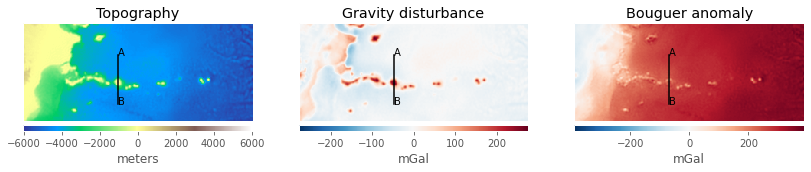

In [38]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(14, 8), subplot_kw=dict(projection=ccrs.Mercator()))

pn = data.h_over_ell.plot.pcolormesh(ax=ax1, cmap="terrain", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pn, ax=ax1, orientation="horizontal", pad=0.01, aspect=40, label="meters")
ax1.plot(profile_topo.longitude, profile_topo.latitude, "-k", transform=ccrs.PlateCarree())
ax1.text(start[0], start[1], "A", transform=ccrs.PlateCarree())
ax1.text(end[0], end[1], "B", transform=ccrs.PlateCarree())
ax1.set_title("Topography")
ax1.set_extent(region,crs=ccrs.PlateCarree())

pd = data.disturbance.plot.pcolormesh(ax=ax2, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pd, ax=ax2, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax2.plot(profile_dist.longitude, profile_dist.latitude, "-k", transform=ccrs.PlateCarree())
ax2.text(start[0], start[1], "A", transform=ccrs.PlateCarree())
ax2.text(end[0], end[1], "B", transform=ccrs.PlateCarree())
ax2.set_title("Gravity disturbance")
ax2.set_extent(region,crs=ccrs.PlateCarree())

pb = data.disturbance_bouguer.plot.pcolormesh(ax=ax3, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pb, ax=ax3, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax3.plot(profile_bouguer.longitude, profile_bouguer.latitude, "-k", transform=ccrs.PlateCarree())
ax3.text(start[0], start[1], "A", transform=ccrs.PlateCarree())
ax3.text(end[0], end[1], "B", transform=ccrs.PlateCarree())
ax3.set_title("Bouguer anomaly")
ax3.set_extent(region,crs=ccrs.PlateCarree())

file_name = 'images/profile_Hawaii'
plt.savefig(file_name+'.png',dpi=300)

plt.show()

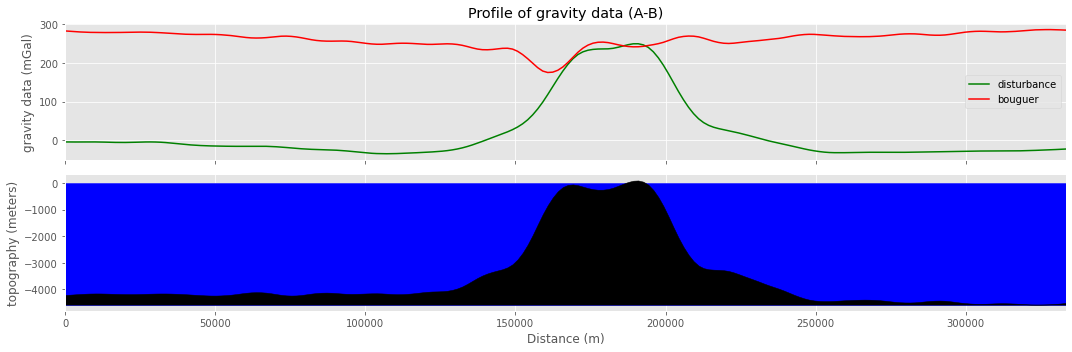

In [39]:
fig,(ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(15, 5))

### Disturbio e anomalia bouguer (com a topografia)
ax1.set_title("Profile of gravity data (A-B)")
ax1.plot(profile_dist.distance, profile_dist.disturbance, "-g",label='disturbance')
ax1.plot(profile_bouguer.distance, profile_bouguer.bouguer, "-r",label='bouguer')
ax1.set_ylabel("gravity data (mGal)")
ax1.set_xlim(profile_dist.distance.min(), profile_dist.distance.max())
ax1.legend()

### Topografia e o nível do mar
ax2.fill_between(profile_topo.distance,0.,min(profile_topo.topography),color='blue')
ax2.fill_between(profile_topo.distance,profile_topo.topography,min(profile_topo.topography),color='black')
ax2.set_ylabel("topography (meters)")
ax2.set_xlim(profile_topo.distance.min(), profile_topo.distance.max())
ax2.set_xlabel("Distance (m)")

file_name = 'images/disturbance_bouguer_Hawaii'
plt.savefig(file_name+'.png',dpi=300)

plt.tight_layout()
plt.show()